In [1]:
using Plots
using QuadGK
using LaTeXStrings

In [15]:
pyplot()

In [105]:
const mπ = 0.14; const mπ2=mπ^2;
const mp = 0.938; const mp2=mp^2;
const Ebeam = 190;
const s0 = mπ2 + mp2 + 2*mp*Ebeam
const mρ = 0.77; const mρ2 = mρ^2;

In [106]:
λ(x,y,z) = x^2+y^2+z^2-2x*y-2y*z-2z*x
t1(t,s,σ,cosθ) = σ+mπ2-(s+σ-mπ2)*(s+mπ2-t)/(2s)+sqrt(λ(s,σ,mπ2)*λ(s,mπ2,t))/(2s)*cosθ
cosγ(s0,t,s,σ)=(2s*(s0+t-s-mp2)-(s+mπ2-t)*(s0-s-mp2))/sqrt(λ(s,mπ2,t)*λ(s0,s,mp2))
cosψ(t,s,σ,t1)=((s+σ-mπ2)*(t1+σ-mπ2)-2σ*(σ+t-2mπ2))/sqrt(λ(s,σ,mπ2)*λ(σ,t1,mπ2))
Tπp0(s0,t,s,σ,cosθ) = mπ2+mp2+(s0-s-mp2)*(s+mπ2-σ)/(2s)-sqrt(λ(s,σ,mπ2)*λ(s0,s,mp2))/(2s)*cosθ*cosγ(s0,t,s,σ)# +
#     (t - 2mp2 - t1(t,s,σ,cosθ) - mπ2) / 2
Tπp1(s0,t,s,σ,cosθ) = -sqrt(λ(s,σ,mπ2)*λ(s0,s,mp2))/(2s)*sqrt(1-cosθ^2)*sqrt(1-cosγ(s0,t,s,σ)^2)
Tπp(M,s0,t,s,σ,cosθ) = M==0 ? Tπp0(s0,t,s,σ,cosθ) : (abs(M)==1 ? Tπp1(s0,t,s,σ,cosθ) : 0)
tminmax(s) = mπ2+s-(s0+mπ2-mp2)*(s0+s-mp2)/(2s0)+sqrt(λ(s0,s,mp2)*λ(s0,mπ2,mp2))/(2s0) * [-1.0,1.0];

In [107]:
const logfact = [sum(log(n) for n in 1:i) for i in 1:50]
lf(i) = (i>0) ? logfact[i] :  0.0;

function Wignerd(aj, am, an, β)
    (β == 0.0) && return (am==an) ? 1.0 : 0.0
    (β ≈ π) && return (am==-an) ? ((aj-am)%2==1 ? -1.0 : 1.0)  : 0.0

    jpm = aj+am;
    jpn = aj+an;
    jmm = aj-am;
    jmn = aj-an;
    mpn = am+an;

    # common prefactor
    pref = (lf(jpm)+lf(jmm)+lf(jpn)+lf(jmn))/2.0

    #
    sb2 = sin(β/2)
    s  = log(sb2)          # log(sin(β/2))
    c  = log(1-sb2^2)/2.0    # log(cos(β/2))

    res = 0.0
    let k0 = max(0,mpn), sgn = ((k0+jpm)%2==1 ? -1 : 1)
        for k in k0:min(jpm,jpn)
            res += sgn*exp(pref-
                    lf(jpm-k)-lf(k)-lf(k-mpn)-lf(jpn-k)+
                    (2k-mpn)*c + (jpm+jpn-2k)*s)
            sgn *= -1;
        end
    end
    res
end

Wignerd (generic function with 1 method)

### Deck amplitude

In [135]:
# namedeck="standard_deck"
namedeck="reggeized_deck"

"reggeized_deck"

In [145]:
##
function DeckBulk(λl,S,s0,t,s,σ,cosθ)
    _t1 = t1(t,s,σ,cosθ)
    # cos of Wigner angle
    _cosψ = cosψ(t,s,σ,_t1)
    (_cosψ ≈ 1) && (_cosψ = 1)
    (_cosψ ≈ -1) && (_cosψ = -1)
    _ψ = acos(_cosψ)    
    v = sqrt((2S+1))*Wignerd(S,0,λl,_ψ)/(mπ2 - _t1)
#     return v
    #
    # other model with Regge factor
    α = _t1-mπ2
    regge_exp = exp(-1im*π*α/2)
    regge_fct = (s-mπ2+(_t1-t-σ)/2)^α
    regge = regge_fct*real(regge_exp)
    return v*regge
end
function DeckReduced(M,λl,S,s0,t,s,σ,cosθ)
    v = DeckBulk(λl,S,s0,t,s,σ,cosθ)*Tπp(M,s0,t,s,σ,cosθ)
    v
end

DeckReduced (generic function with 1 method)

### Intensity

In [137]:
function intens(S,λl,t,s,σ,cosθ)
    _BSλ = DeckBulk(λl,S,s0,t,s,σ,cosθ)
    _Tπp0 = Tπp0(s0,t,s,σ,cosθ)
    _Tπp1 = Tπp1(s0,t,s,σ,cosθ)
    v = abs2(_BSλ)#*(_Tπp0^2+2*_Tπp1^2)
    ρ = sqrt(λ(s,σ,mπ2))/(8π*s)
    v*ρ
end

intens (generic function with 1 method)

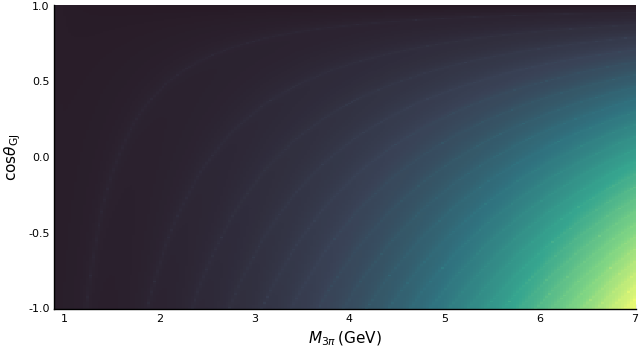

In [156]:
let ev = linspace(mρ+mπ+1e-3,7,200), cosθv=linspace(-1,1,200)
    cal = [intens(0,0,-0.1,x^2,mρ2,y)*x for y in cosθv, x in ev]
#     cal = [log10(c)<2. ? NaN : c for c in cal]
    heatmap(ev,cosθv,log10.(cal), c=:lime_grad,size=(640,350),colorbar=false,
        xlab=L"$M_{3\pi}\,(\mathrm{GeV})$", ylab=L"$\cos\theta_{\mathrm{GJ}}$")
end

In [139]:
savefig("../plots/3pi_vs_cos_$(namedeck).pdf")

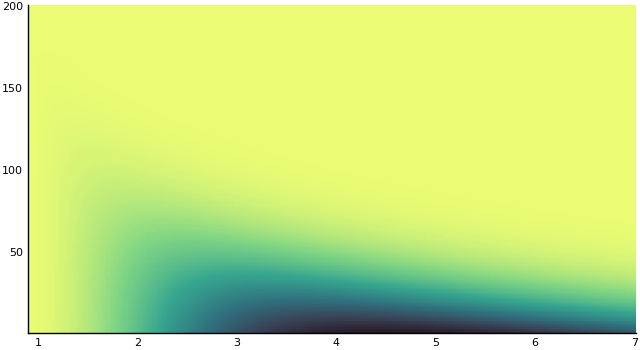

In [140]:
let ev = linspace(mρ+mπ+1e-3,7,200), cosθv=1-exp.(linspace(log(0.001),log(1),200))
    cal = [intens(0,0,-0.1,x^2,mρ2,y)*x for y in cosθv, x in ev]
#     cal = [log10(c)<2. ? NaN : c for c in cal]
    heatmap(ev,1:length(cosθv),(cal), c=:lime_grad,size=(640,350),colorbar=false)
end

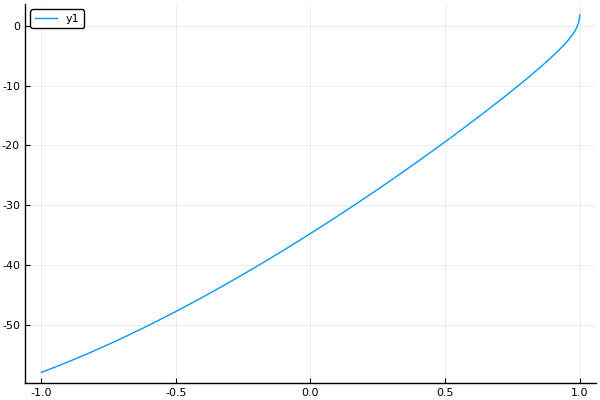

In [141]:
let s = 5.0^2, cosθv=linspace(-1,1,500)
    cal = [intens(0,0,-0.1,s,mρ2,y) for y in cosθv]
    plot(cosθv,log10.(cal))
end

### Partial waves

In [142]:
function projection(J,M,S,λ,t,s,σ)
    function integrand(cosθ)
        Wignerd(J,M,λ,acos(cosθ))*DeckReduced(M,λ,S,s0,t,s,σ,cosθ)
    end
    sqrt(2J+1)*quadgk(integrand,-1,1-1e-5)[1]/2
end

projection (generic function with 1 method)

In [143]:
function projection_approx(J,M,S,λl,t,s,σ)
    (λl != 0 || M != 0) && return 0
    function integrand(cosθ)
        _t1 = -s/2*(1-cosθ)
#         _cosγ = cosγ(s0,t,s,σ)
        θ = acos(cosθ)
        _Tπp = mπ2+mp2+(s0-s-mp2)*(s-σ+mπ2)/(2s)-sqrt(λ(s,σ,mπ2)*λ(s0,s,mp2))/(2s)*cosθ
#         _Tπp =  mp2+(s0-s)/2-sqrt(λ(s0,s,mp2))/2*cosθ
        Wignerd(J,0,0,θ)/(mπ2 - _t1)*_Tπp
    end
    sqrt((2J+1)*(2S+1))*quadgk(integrand,-1,1-1e-5)[1]/2
end

projection_approx (generic function with 1 method)

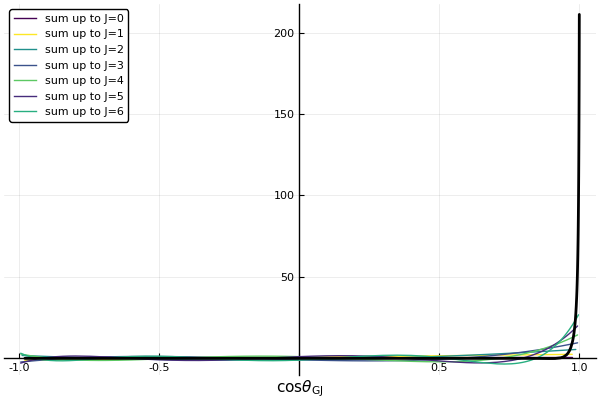

In [147]:
let M=0, λl=0, S=0, t=-0.5,s = 5^2
    plot(frame=:origin)
    coeff = [projection(J,M,S,λl,t,s,mρ2) for J=0:6]
    pallete = get_color_palette(:viridis, plot_color(:white), length(coeff))
    for Jp1 in 1:length(coeff)
        plot!(cosθ->sum(sqrt(2(j-1)+1)*Wignerd(j-1,0,0,acos(cosθ))*coeff[j] for j=1:Jp1), -1, 1,
            lab="sum up to J=$(Jp1-1)", leg=:topleft,
            lc=pallete[Jp1], lw=1,
            xlab=L"$\cos\theta_\mathrm{GJ}$")
    end
    plot!(cosθ->DeckReduced(0,0,0,s0,t,s,mρ2,cosθ), -1, 1, l=(:black,2), lab="")
end
annotate!([(0.38,230,text(L"$t=-0.1\,\mathrm{GeV}^2,\,M_{3\pi}=5\,\mathrm{GeV}$",10))])

In [148]:
savefig("../plots/cos_till_J6_$(namedeck).pdf")

## Cross checks

### Cross check vs `c++` code

In [119]:
let t = -0.1, s = 5^2
    [2π*projection(J,0,0,0,t,s,mρ2)*2 for J = 0:5]
end

6-element Array{Float64,1}:
 172.767  
  10.0642 
  10.4493 
  10.3952 
  10.1506 
   9.81167

### Cross check vs Ascoli formulas

In [120]:
function tanψ(t,s,σ,cosθ)
    W = √s
    E1 = (s+mπ2-σ)/(2W)
    p1 = sqrt(λ(s,mπ2,σ))/(2W)
    EA = (s+mπ2-t)/(2W)
    pA = sqrt(λ(s,mπ2,t))/(2W)
    sinθ = sqrt(1-cosθ^2)
    √σ*pA*sinθ/((W-E1)*pA*cosθ-p1*EA)
end

tanψ (generic function with 1 method)

In [121]:
function t1_A(t,s,σ,cosθ)
    W = √s
    E1 = (s+mπ2-σ)/(2W)
    p1 = sqrt(λ(s,mπ2,σ))/(2W)
    EA = (s+mπ2-t)/(2W)
    pA = sqrt(λ(s,mπ2,t))/(2W)
    sinθ = sqrt(1-cosθ^2)
    mπ2+σ-2EA*(W-E1)+2pA*p1*cosθ
end

t1_A (generic function with 1 method)

In [122]:
let cosθ=0.77
    t1(-0.1,4^2,mρ2,cosθ), t1_A(-0.1,4^2,mρ2,cosθ)
end

(-1.7826303803479098, -1.7826303803479098)

In [123]:
let cosθ=0.77
    c = cosψ(-0.1,4^2,mρ2,t1(-0.1,4^2,mρ2,cosθ))
    t = tanψ(-0.1,4^2,mρ2,cosθ)
    1/c^2, 1+t^2
end

(3.1802412011231365, 3.1802412011231396)

In [124]:
projection(0,0,0,0,-0.1,4^2,mρ2),
projection_approx(0,0,0,0,-0.1,4^2,mρ2)

(22.137146761080498, 20.863953156528837)

### Plot $M=0$ projections

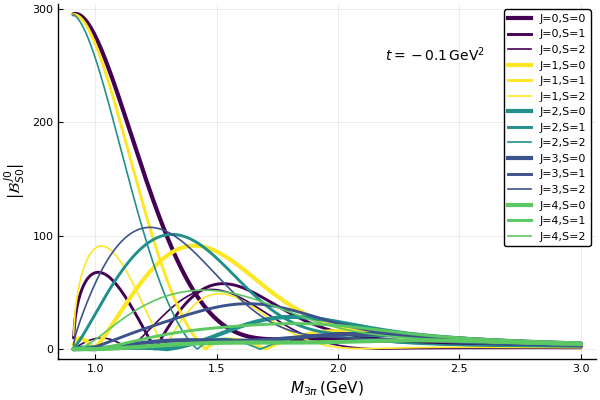

In [149]:
plot()
let ev = linspace(mρ+mπ+0.001,3,300)
# let ev = linspace(2.4,2.4,300)
    lcs=get_color_palette(:viridis, plot_color(:white), 5)
    αs = 3*[1, 0.7, 0.4]
    for J in 0:1:4, S=0:2
        cal = [projection(J,0,S,0,-0.1,e^2,mρ2) for e in ev]
        plot!(ev,abs.(cal), lab="J=$J,S=$S", lc=lcs[J+1], lw=αs[S+1], # lab=((S==0) ? "J=$J" : "")
            xlab=L"$M_{3\pi}\,(\mathrm{GeV})$", ylab=L"$|\mathcal{B}_{S0}^{\,J0}|$")
    end
#     for J in 0:1:3, S=0:2
#         cal = [projection_approx(J,0,S,0,tminmax(e^2)[2]-0.1,e^2,mρ2) for e in ev]
#         plot!(ev, abs.(cal), lab="", lc=:black, ls=:dash)
#     end
end
annotate!([(2.4,260,text(L"$t=-0.1\,\mathrm{GeV}^2$",10))])

In [150]:
savefig("../plots/pw_projections_low_mass_$(namedeck).pdf")

### $M=0$: high ehergy, log plot

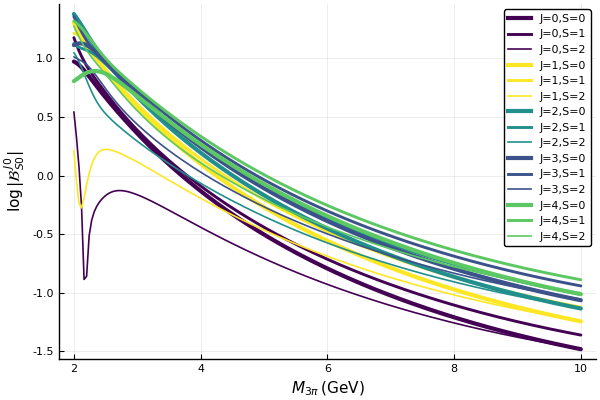

In [151]:
plot()
let ev = linspace(2,10,200)
    lcs=get_color_palette(:viridis, plot_color(:white), 5)
    αs = 3*[1, 0.7, 0.4]
    for J in 0:1:4, S=0:2
        cal = [projection(J,0,S,0,tminmax(e^2)[2]-0.1,e^2,mρ2) for e in ev]
        plot!(ev,log10.(abs.(cal)), lc=lcs[J+1], lw=αs[S+1],
            lab="J=$J,S=$S", xlab=L"$M_{3\pi}\,(\mathrm{GeV})$", ylab=L"$\log\,|\mathcal{B}_{S0}^{\,J0}|$") #J=$J,S=$S
    end
#     for J in 0:1:3, S=0:0
#         cal = [projection_approx(J,0,S,0,tminmax(e^2)[2]-0.1,e^2,mρ2) for e in ev]
#         plot!(ev,log10.(abs.(cal)), lab="", lc=:black, ls=:dash)
#     end
end
plot!(leg=:topright)
annotate!([(7.8,1.8,text(L"$t=-0.1\,\mathrm{GeV}^2$",10))])

In [152]:
savefig("../plots/pw_projections_$(namedeck).pdf")

### Save to files

In [129]:
function save_projection(fout, J,M,S,λ,t)
    ev = linspace(mρ+mπ+0.001,10,600)
    cal = [projection(J,0,S,0,-0.1,e^2,mρ2) for e in ev, S=0:2]
    writedlm(fout, [ev cal])
end
save_projection("/tmp/test.txt", 0,0,0,0,-0.5)
readdlm("/tmp/test.txt")

600×4 Array{Float64,2}:
  0.911     266.267     -7.90487   0.0871317
  0.926174  268.406    -30.9416    1.56695  
  0.941347  269.505    -42.0119    3.22135  
  0.956521  269.728    -49.9924    5.00419  
  0.971694  269.214    -56.3082    6.87801  
  0.986868  268.079    -61.54      8.81238  
  1.00204   266.423    -65.9934   10.7826   
  1.01722   264.332    -69.8525   12.7685   
  1.03239   261.879    -73.2379   14.7538   
  1.04756   259.124    -76.2337   16.7252   
  1.06274   256.123    -78.9007   18.6722   
  1.07791   252.919    -81.285    20.5862   
  1.09308   249.554    -83.4222   22.4604   
  ⋮                                         
  9.83309     2.78773   -4.43909   5.37409  
  9.84826     2.77604   -4.421     5.35306  
  9.86344     2.7644    -4.40298   5.33212  
  9.87861     2.75282   -4.38505   5.31126  
  9.89378     2.7413    -4.36719   5.29049  
  9.90896     2.72982   -4.34941   5.2698   
  9.92413     2.7184    -4.33171   5.24919  
  9.93931     2.70703   -4.3140

In [130]:
# [save_projection("../data/projection.Deck.rhopi.J=$J.M=0.t=-0.5.txt", J,0,0,0,-0.5) for J in 0:4]

### Bar plot of projection

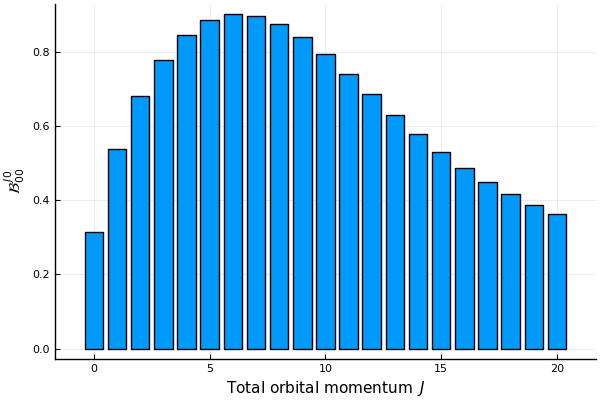

In [153]:
plot()
let Jv = 0:1:20, e = 5.0, s = e^2
    cal = [projection(J,0,0,0,tminmax(e^2)[2]-0.1,e^2,mρ2) for J in Jv]
    bar!(Jv,cal, lab="", xlab=L"$\mathrm{Total\,\,orbital\,\,momentum}\,\,\,J$",
        ylab=L"$\mathcal{B}^{\,J0}_{00}$")
#     cal = [projection(J,0,0,0,tminmax(e^2)[2]-0.01,e^2,mρ2) for J in Jv]
#     bar!(Jv,cal, lab="")
end
annotate!([(17,12.5,text(L"$t=-0.1\,\mathrm{GeV}^2,\,M_{3\pi}=5\,\mathrm{GeV}$",10))])

In [154]:
savefig("../plots/PWbar_$(namedeck).pdf")

### M=1 projections

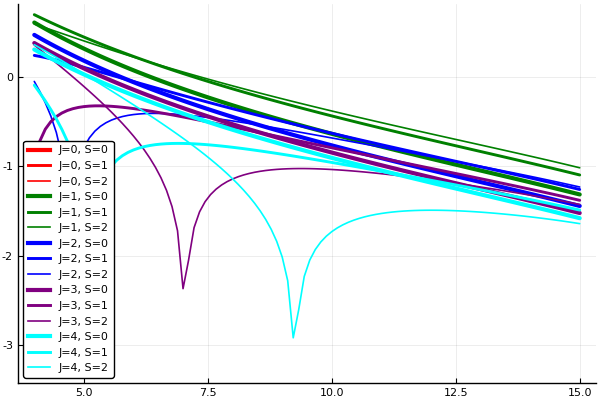

In [104]:
plot()
let ev = linspace(4,15,100)
    lcs=[:red, :green, :blue, :purple, :cyan]
    αs = 3*[1, 0.7, 0.4]
    for J in 0:1:4, S=0:2
        cal = [projection(J,1,S,0,tminmax(e^2)[2]-0.1,e^2,mρ2) for e in ev]
        plot!(ev,log10.(abs.(cal)), lab="J=$J, S=$S", lc=lcs[J+1], lw=αs[S+1])
    end
end
plot!(leg=:bottomleft)